# Machine Learning Tests on WWW

## Basic imports, setups

In [2]:
print("Have a great day!")
import os, time, sys
start_time = time.time()
import pandas as pd
import numpy as np
from itertools import accumulate
print("import sklearn")
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, LabelBinarizer, scale
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from sklearn.externals import joblib
from sklearn.model_selection import RandomizedSearchCV
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
print("import matplotlib")
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from matplotlib.colors import LogNorm
%matplotlib inline
print("import torch")
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
print("import xgboost")
from tqdm import tqdm
from xgboost import XGBClassifier
import xgboost as xgb
print("import ROOT + others")
import ROOT
print("Fix random number generators")
np.random.seed(24)
torch.manual_seed(24)
total_lumi = 36
print("--- %.2f seconds ---" % (time.time() - start_time))

Have a great day!
import sklearn
import matplotlib
import torch
import xgboost
import ROOT + others
Fix random number generators
--- 0.49 seconds ---


## Load Data and Cleaning

In [3]:
def get_data(data_dir, name_str=["signal"]):
    fs = []
    for f in os.listdir(data_dir):
        for s in name_str:
            if (s in f) and f[0] != '.':
                fs.append(data_dir + f)
    df = pd.DataFrame()
    for f in fs:
        print("adding", f)
        new_df = pd.read_csv(f, compression="gzip")
        df = pd.concat([df, new_df], ignore_index = True)
        df.index = range(len(df))
    print("done merging data")
    return df

def add_cl_ix(df):
    df['is_sig'] = [1 if 'signal' in val else 0 for val in df.cl.values]
    return df

data_dir = '../data/' # Modify this
#df_all = get_data(data_dir, name_str=["signal", "bkg"])
#df_all = add_cl_ix(df_all)

In [4]:
#df_data = get_data(data_dir, name_str=["data"])
#df_data = add_cl_ix(df_data)
##df_data.to_csv('../data/df_data.gz', compression="gzip") ##if save

### Set the explicit flavor; add in fixed cuts

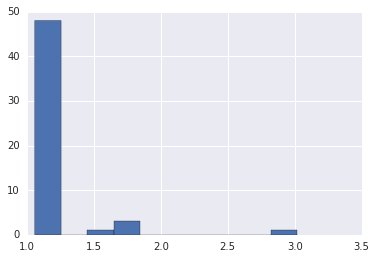

/cvmfs/sft.cern.ch/lcg/views/LCG_91python3/x86_64-slc6-gcc62-opt/lib/python3.5/site-packages/pandas/core/indexing.py:476: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [8]:
## copy into 3 different dfs
df_0 = df_all.loc[df_all.SFOS == 0, :]
df_1 = df_all.loc[df_all.SFOS == 1, :]
df_2 = df_all.loc[df_all.SFOS == 2, :]
## quick check
plt.clf()
#print(df_all.loc[abs(df_all.weight) > 20, 'cl'])
plt.hist(df_all.loc[abs(df_all.weight) > 1, 'weight'])
plt.show()
##quick clean
df_0.loc[abs(df_0.weight) > 10, 'weight'] = 0
df_1.loc[abs(df_1.weight) > 10, 'weight'] = 0
df_2.loc[abs(df_2.weight) > 10, 'weight'] = 0
#print(df_0.shape[0], df_1.shape[0], df_2.shape[0])
##add fixed cuts; mask the bjet is the correct training strategy
df_0 = df_0.query('Nbjet < 1')
df_1 = df_1.query('Nbjet < 1')
df_2 = df_2.query('Nbjet < 1')
# df_0 = df_0.query('Njet < 2')
# df_1 = df_1.query('Njet < 2')
# df_2 = df_2.query('Njet < 2')
# df_0 = df_0.query('passSel == 1')
# df_1 = df_1.query('passSel == 1')
# df_2 = df_2.query('passSel == 1')

##save as temp csvs
##df_0.to_csv('../data/df_0.gz', compression="gzip")
##df_1.to_csv('../data/df_1.gz', compression="gzip")
##df_2.to_csv('../data/df_2.gz', compression="gzip")

## Express Data loading

In [5]:
## quick load from pre-processed csvs
df_0 = pd.read_csv('../data/df_0.gz', compression="gzip")
df_1 = pd.read_csv('../data/df_1.gz', compression="gzip")
df_2 = pd.read_csv('../data/df_2.gz', compression="gzip")
df_data = pd.read_csv('../data/df_data.gz', compression="gzip")

In [6]:
##split training and testing
split_factor = 0.7
df_0_tr, df_0_te = train_test_split(df_0, train_size=split_factor)
df_1_tr, df_1_te = train_test_split(df_1, train_size=split_factor)
df_2_tr, df_2_te = train_test_split(df_2, train_size=split_factor)
#print(df_0.shape[0], df_1.shape[0], df_2.shape[0])
#print(df_0_tr.shape[0], df_1_tr.shape[0], df_2_tr.shape[0])
print("train sig", df_0_tr.query('is_sig == 1').shape[0], df_1_tr.query('is_sig == 1').shape[0], df_2_tr.query('is_sig == 1').shape[0])
print("train bkg", df_0_tr.query('is_sig == 0').shape[0], df_1_tr.query('is_sig == 0').shape[0], df_2_tr.query('is_sig == 0').shape[0])
print("test  sig", df_0_te.query('is_sig == 1').shape[0], df_1_te.query('is_sig == 1').shape[0], df_2_te.query('is_sig == 1').shape[0])
print("test  bkg", df_0_te.query('is_sig == 0').shape[0], df_1_te.query('is_sig == 0').shape[0], df_2_te.query('is_sig == 0').shape[0])

train sig 52103 100974 51053
train bkg 24689 315617 332680
test  sig 22279 43639 21966
test  bkg 10633 134901 142491


In [7]:
## Test PCA on the features; LCA is a linear classifier
## In other words, PCA projects the entire dataset onto a different feature (sub)space, 
def quick_test(df, x_cols):
    pca = PCA(n_components=2)
    X = df[x_cols]
    y = np.array(df["is_sig"]) ##doesn't like panda
    lda = LinearDiscriminantAnalysis(n_components=2)
    X_lda = lda.fit_transform(X, y)
    qda = QuadraticDiscriminantAnalysis(reg_param=0.5)
    qda.fit(X, y)
    X_r = pca.fit(X).transform(X) ## [ 0.61414621  0.13204857]
    print('explained variance ratio (first two components): %s'
          % str(pca.explained_variance_ratio_))
    print("lda", metrics.accuracy_score(y, lda.predict(X)))
    print("qda", metrics.accuracy_score(y, qda.predict(X)))
    #print(X.shape, X_r.shape)
    plt.clf()
    # plt.scatter(X_r[y==0, 0], X_r[y==0, 1], alpha=.8, lw=2)
    for color, i, target_name in zip(("blue", "green"), [0, 1], ("bkg", "sig")):
        plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.2, label=target_name)
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title('PCA of SFOS0 dataset')
    return

#quick_test(df_0_tr, x_cols)

In [8]:
## A new more systematic approach
def modelfit(alg, dtrain, predictors, useTrainCV=True, param_grid={}, cv_folds=5, batches=1, early_stopping_rounds=50):
#https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
#https://www.dataiku.com/learn/guide/code/python/advanced-xgboost-tuning.html    
    
    df_tr_temp, df_te_temp = train_test_split(dtrain, train_size=0.9)
    
    df_tr_temp1, df_tr_temp2 = train_test_split(df_tr_temp, train_size=0.5, )
    
    if useTrainCV:
#         xgb_param = alg.get_xgb_params()
#         xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain["is_sig"].values)
#         cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
#             metrics='auc', early_stopping_rounds=early_stopping_rounds)
#         alg.set_params(n_estimators=cvresult.shape[0])
        
        ##Randomized Search CV
        random_search = RandomizedSearchCV(alg, param_grid, n_iter=10, cv=3, refit=True, verbose=2, n_jobs=4)
        random_search.fit(dtrain[predictors], dtrain["is_sig"])
        report(random_search.cv_results_)
        
        ##Grid search CV
        #gsearch1 = GridSearchCV(estimator = alg, param_grid = param_grid, scoring='roc_auc',n_jobs=4, iid=False, cv=5)
        #gsearch1.fit(dtrain[predictors], dtrain["is_sig"], eval_metric="auc", early_stopping_rounds=30)
        #print(gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_)
    
    if batches <= 1:
        alg.fit(df_tr_temp[predictors], df_tr_temp["is_sig"], sample_weight=None, 
                eval_set=[(df_tr_temp[predictors], df_tr_temp["is_sig"]), (df_te_temp[predictors], df_te_temp["is_sig"])],
                eval_metric="auc")
    else:
        ##batch this doesn't really work for decision trees
        alg.fit(df_tr_temp1[predictors], df_tr_temp1["is_sig"], sample_weight=None, 
                eval_set=[(df_tr_temp1[predictors], df_tr_temp1["is_sig"]), (df_te_temp[predictors], df_te_temp["is_sig"])],
                eval_metric="auc")
        alg._Booster.save_model('model_1.model')
        alg.fit(df_tr_temp2[predictors], df_tr_temp2["is_sig"], sample_weight=None, 
                eval_set=[(df_tr_temp2[predictors], df_tr_temp2["is_sig"]), (df_te_temp[predictors], df_te_temp["is_sig"])],
                eval_metric="auc", xgb_model='model_1.model')
    
    #Predict training set:
    dtrain_predictions = alg.predict(df_tr_temp[predictors])
    dtrain_predprob    = alg.predict_proba(df_tr_temp[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(df_tr_temp["is_sig"].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(df_tr_temp["is_sig"], dtrain_predprob))
    
    return True

    
def training(df, features, name="xgb_temp", optimize=False):
    
    param_grid = {
            'learning_rate': [.05, .3], 
            'max_depth': range(3, 9, 1), 
            #'gamma' : [0.01, .1], 
            #'subsample': [.5, .9], 
            #'colsample_bytree': [.5, .9]
    }
    
    xgb_temp = XGBClassifier(
        max_depth = 6, #Maximum tree depth for base learners.
        learning_rate = 0.09, #Boosting learning rate (XGBoost's "eta")
        n_estimators= 100, ## Number of boosted trees, CV doesn't change after ~ 90
        ##silent = False, ##print messages or not
        objective= 'binary:logistic',
        nthread=-1,
        gamma=0.02, #Minimum loss reduction required to make a further partition on a leaf node of the tree.
        min_child_weight=1, # Minimum sum of instance weight(hessian) needed in a child.
        scale_pos_weight=1,
        reg_alpha=0.005,
        reg_lambda=0.005,
        subsample=0.6, #Subsample ratio of the training instance.
        colsample_bytree = 0.55, #Subsample ratio of columns when constructing each tree.
        seed=24)
    
    if optimize:
        modelfit(xgb_temp, df, features, param_grid=param_grid)
        joblib.dump(param_grid.best_estimator_, name + ".parlib.dat")
    else:
        modelfit(xgb_temp, df, features, useTrainCV=False)
    
    ##save model
    joblib.dump(xgb_temp, name + ".joblib.dat")
    ##load model
    ##loaded_model = joblib.load("pima.joblib.dat")
    
    plt.clf()
    fig = plt.figure(figsize=(10,6))
    feat_imp = pd.Series(xgb_temp._Booster.get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    plt.savefig('../plots/feature_ranking_' + name + '.pdf')

    return xgb_temp

In [9]:
## Feature columns
## El, c are label encoded;
## Default no scaling is necessary
## WZ search use lepton pT cut at 25 GeV; 30 GeV jets; and pT_w/m_wz & pT_z/m_wz > 0.35; veto 4th lepton 7 GeV

x_cols = [
#           'l0_l1_m', 'l0_l1_pt', 'l0_l1_c', 
#           'l1_l2_m', 'l1_l2_pt', 'l1_l2_c', 
#           'l2_l0_m', 'l2_l0_pt', 'l2_l0_c', 
          #'l0_l1_isEl', 'l1_l2_isEl', 'l2_l0_isEl', 
          #'l0_phi', 'l1_phi', 'l2_phi', 
          'l0_pt', 'l1_pt', 'l2_pt', 
          'Z_m', 'Z_pt', 
          'Z_c', 'Z_isEl',
#           'W_mt', 'W_pt',
          'm_3l', 'pt_3l', 
          'mt_3l',  
          'dphi_3l_met',
          #'mnew_3l', 
          'met_pt',
          #'Nmu',
          'j0_pt',
          #'met_phi',
         ]

x_cols_new = ["l0_m","l0_pt","l0_eta","l0_phi", "l0_isEl", "l0_c",
              "l1_m","l1_pt","l1_eta","l1_phi", "l1_isEl", "l1_c",
              "l2_m","l2_pt","l2_eta","l2_phi", "l2_isEl", "l2_c",
              "pt_3l","mt_3l", "mnew_3l", 
              "met_pt", "met_phi", 
              "Nmu", "Nel", "j0_pt",
             ]
#print(x_cols, x_cols_new, df.columns)

[0]	validation_0-auc:0.747259	validation_1-auc:0.740641
[1]	validation_0-auc:0.762782	validation_1-auc:0.756075
[2]	validation_0-auc:0.784985	validation_1-auc:0.77922
[3]	validation_0-auc:0.785623	validation_1-auc:0.778798
[4]	validation_0-auc:0.787869	validation_1-auc:0.779754
[5]	validation_0-auc:0.791579	validation_1-auc:0.781951
[6]	validation_0-auc:0.790576	validation_1-auc:0.780537
[7]	validation_0-auc:0.79457	validation_1-auc:0.78482
[8]	validation_0-auc:0.799091	validation_1-auc:0.789605
[9]	validation_0-auc:0.800712	validation_1-auc:0.790708
[10]	validation_0-auc:0.801683	validation_1-auc:0.792676
[11]	validation_0-auc:0.802029	validation_1-auc:0.79222
[12]	validation_0-auc:0.803085	validation_1-auc:0.792693
[13]	validation_0-auc:0.803497	validation_1-auc:0.792794
[14]	validation_0-auc:0.80393	validation_1-auc:0.793031
[15]	validation_0-auc:0.806462	validation_1-auc:0.795454
[16]	validation_0-auc:0.808567	validation_1-auc:0.797907
[17]	validation_0-auc:0.808473	validation_1-au

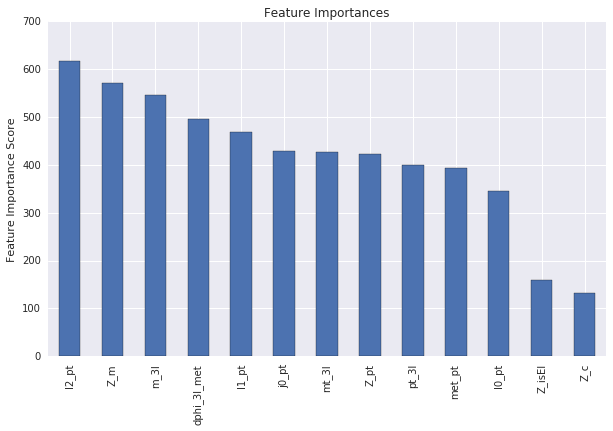

In [10]:
##Cut based sig is 1.050
##with W, Z, l pT, allpair, 3l -- 0.815/0.877; test Sig 1.826
##with W, Z, allpair, 3l -- 0.806/0.868; test Sig 1.951
##with W, Z, l pT, 3l -- 0.779/0.836; test Sig 1.456
##with Z, l pT, 3l -- 0.778/0.834; test Sig 1.543
##with Z, l pT -- 0.771/0.823; test Sig 1.485 --hints the baseline cuts needs to be tuned
xgb_0 = training(df_0_tr, x_cols, name="xgb_0")

[0]	validation_0-auc:0.806322	validation_1-auc:0.804969
[1]	validation_0-auc:0.867793	validation_1-auc:0.866401
[2]	validation_0-auc:0.874037	validation_1-auc:0.872914
[3]	validation_0-auc:0.875381	validation_1-auc:0.874305
[4]	validation_0-auc:0.878794	validation_1-auc:0.878016
[5]	validation_0-auc:0.879422	validation_1-auc:0.878477
[6]	validation_0-auc:0.880163	validation_1-auc:0.879206
[7]	validation_0-auc:0.881549	validation_1-auc:0.880544
[8]	validation_0-auc:0.881991	validation_1-auc:0.880738
[9]	validation_0-auc:0.882917	validation_1-auc:0.881503
[10]	validation_0-auc:0.884842	validation_1-auc:0.883535
[11]	validation_0-auc:0.885261	validation_1-auc:0.883898
[12]	validation_0-auc:0.884762	validation_1-auc:0.883407
[13]	validation_0-auc:0.885114	validation_1-auc:0.883839
[14]	validation_0-auc:0.885241	validation_1-auc:0.884057
[15]	validation_0-auc:0.885112	validation_1-auc:0.883887
[16]	validation_0-auc:0.885263	validation_1-auc:0.883919
[17]	validation_0-auc:0.885045	validation

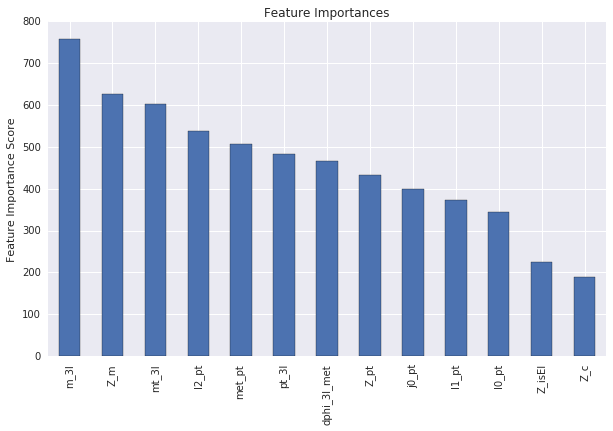

In [11]:
xgb_1 = training(df_1_tr, x_cols, name="xgb_1")

[0]	validation_0-auc:0.768202	validation_1-auc:0.765199
[1]	validation_0-auc:0.778328	validation_1-auc:0.775388
[2]	validation_0-auc:0.805022	validation_1-auc:0.801537
[3]	validation_0-auc:0.860529	validation_1-auc:0.858666
[4]	validation_0-auc:0.853395	validation_1-auc:0.851198
[5]	validation_0-auc:0.869447	validation_1-auc:0.867294
[6]	validation_0-auc:0.868831	validation_1-auc:0.866095
[7]	validation_0-auc:0.865671	validation_1-auc:0.863075
[8]	validation_0-auc:0.872319	validation_1-auc:0.870005
[9]	validation_0-auc:0.871872	validation_1-auc:0.869268
[10]	validation_0-auc:0.871031	validation_1-auc:0.868514
[11]	validation_0-auc:0.876127	validation_1-auc:0.873886
[12]	validation_0-auc:0.878854	validation_1-auc:0.876884
[13]	validation_0-auc:0.880612	validation_1-auc:0.879162
[14]	validation_0-auc:0.881447	validation_1-auc:0.880037
[15]	validation_0-auc:0.881623	validation_1-auc:0.880262
[16]	validation_0-auc:0.881977	validation_1-auc:0.880929
[17]	validation_0-auc:0.88214	validation_

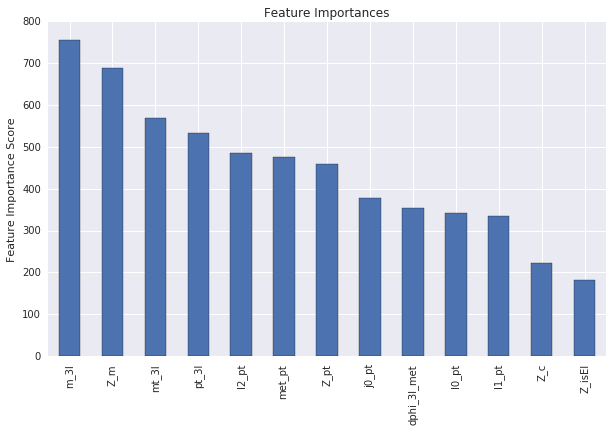

In [12]:
xgb_2 = training(df_2_tr, x_cols, name="xgb_2")

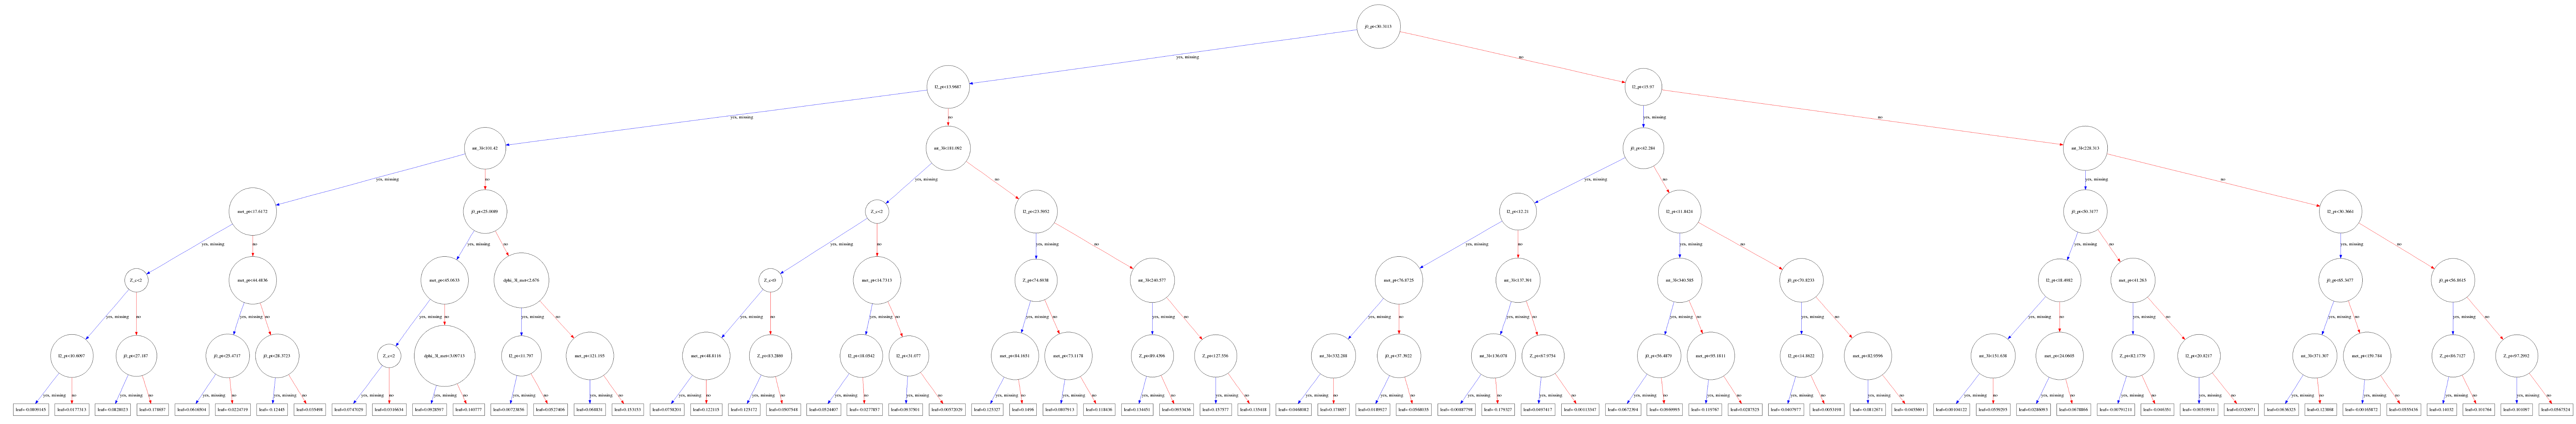

In [13]:
##check the tree
plt.clf()
xgb.plot_tree(xgb_0, num_trees=0)
fig = plt.gcf()
fig.set_size_inches(150, 100)
fig.savefig('../plots/tree.pdf')
#xgb.to_graphviz(xgb_0, num_trees=2)

## Check output performance

In [14]:
#model = xgb1
df_0_te = df_0_te.query('Nbjet < 1')
df_1_te = df_1_te.query('Nbjet < 1')
df_2_te = df_2_te.query('Nbjet < 1')
df_0_te = df_0_te.query('Njet < 2')
df_1_te = df_1_te.query('Njet < 2')
df_2_te = df_2_te.query('Njet < 2')
df_0_te = df_0_te.query('passSel == 1')
df_1_te = df_1_te.query('passSel == 1')
df_2_te = df_2_te.query('passSel == 1')

#df_0_te = df_0_te.query('l0_pt > 25')
#df_0_te = df_0_te.query('l1_pt > 20')
#df_0_te = df_0_te.query('l2_pt > 20')
#df_0_te = df_0_te.query('dphi_3l_met > 2.4')

df_0_te['preds'] = xgb_0.predict_proba(df_0_te[x_cols])[:,1]
df_1_te['preds'] = xgb_1.predict_proba(df_1_te[x_cols])[:,1]
df_2_te['preds'] = xgb_2.predict_proba(df_2_te[x_cols])[:,1]

In [15]:
## Baseline performance
def cutbased_sig(df):
    lumi_rescale = total_lumi / (36 * ( 1 - split_factor))
    df["cutweight"] = df["weight"].copy()
    original_weight = df.cutweight.sum() * lumi_rescale

    ## Tau veto
    ## This is going to be a minor effect. Ignore for now

    ## Fiducial Leptons
    ## lepton pt cut
    df.loc[df.l0_pt <= 20, 'cutweight']= 0
    df.loc[df.l1_pt <= 20, 'cutweight']= 0
    df.loc[df.l2_pt <= 20, 'cutweight']= 0
    
    ## lepton eta cut
    df.loc[abs(df.l0_eta) >= 2.5, 'cutweight']= 0
    df.loc[abs(df.l1_eta) >= 2.5, 'cutweight']= 0
    df.loc[abs(df.l2_eta) >= 2.5, 'cutweight']= 0

    ## Lepton overlap removal 
    ## dR < 0.1
    df.loc[(dR(df.l0_eta, df.l0_phi, df.l1_eta, df.l1_phi)) <= 0.01, 'cutweight']= 0
    df.loc[(dR(df.l2_eta, df.l2_phi, df.l1_eta, df.l1_phi)) <= 0.01, 'cutweight']= 0
    df.loc[(dR(df.l0_eta, df.l0_phi, df.l2_eta, df.l2_phi)) <= 0.01, 'cutweight']= 0
    
    ## Met lep angle cut > 2.5
    df.loc[abs(map_phi(df.phi_3l) - map_phi(df.met_phi)) < 2.5, 'cutweight']= 0

    ## Met specific cut
    ## For SFOS--1
    df.loc[(df.SFOS == 1) & (df.met_pt < 45), 'cutweight']= 0
    ## For SFOS--2
    df.loc[(df.SFOS == 2) & (df.met_pt < 55), 'cutweight']= 0

    ## SF Mass for SFOS--0
    df.loc[(df.SFOS == 0) & (((df.l0_l1_isEl % 2 == 0) 
        & (df.l0_l1_m < 20)) | ((df.l1_l2_isEl % 2 == 0) 
        & (df.l1_l2_m < 20)) | ((df.l2_l0_isEl % 2 == 0) 
        & (df.l2_l0_m < 20))), 'cutweight']= 0

    ## Z veto
    ## for SFOS--0
    df.loc[(df.SFOS == 0) 
        & (((df.l0_l1_isEl == 2) & ((df.l0_l1_m > 75) & (df.l0_l1_m < 105))) 
        | ((df.l1_l2_isEl  == 2) & ((df.l1_l2_m > 75) & (df.l1_l2_m < 105))) 
        | ((df.l2_l0_isEl  == 2) & ((df.l2_l0_m > 75) & (df.l2_l0_m < 105)))), 'cutweight']= 0
    ## for SFOS--1
    df.loc[(df.SFOS == 1) &
        ( (((df.l0_l1_isEl % 2 == 0) & (df.l0_l1_c == 0)) & ((df.l0_l1_m > 55) & (df.l0_l1_m < 110))) 
        | (((df.l1_l2_isEl % 2 == 0) & (df.l1_l2_c == 0)) & ((df.l1_l2_m > 55) & (df.l1_l2_m < 110))) 
        | (((df.l2_l0_isEl % 2 == 0) & (df.l2_l0_c == 0)) & ((df.l2_l0_m > 55) & (df.l2_l0_m < 110)))
        ), 'cutweight']= 0
    ## for SFOS--2
    df.loc[(df.SFOS == 2) &
        ( (((df.l0_l1_isEl % 2 == 0) & (df.l0_l1_c == 0)) & ((df.l0_l1_m > 70) & (df.l0_l1_m < 110))) 
        | (((df.l1_l2_isEl % 2 == 0) & (df.l1_l2_c == 0)) & ((df.l1_l2_m > 70) & (df.l1_l2_m < 110))) 
        | (((df.l2_l0_isEl % 2 == 0) & (df.l2_l0_c == 0)) & ((df.l2_l0_m > 70) & (df.l2_l0_m < 110)))
        ), 'cutweight']= 0

    # ## Inclusive jet veto; could be ignored
    df.loc[(df.Njet > 1), 'cutweight'] = 0

    # ## Inclusive b-jet veto; could be ignored 
    df.loc[(df.Nbjet > 0), 'cutweight'] = 0
    
    # ## Tight lepton cut 
    df.loc[(df.passSel == 0), 'cutweight'] = 0
    
    ## For SFOS--0 Extra cuts
    ##df.loc[(df.SFOS == 0) & (df.l1_l2_c != 0), 'cutweight']= 0

    ## Check total weight
    final_weight = df.cutweight.sum() * lumi_rescale
    final_weight_sig =  df.query('is_sig == 1').cutweight.sum() * lumi_rescale
    final_weight_bkg =  df.query('is_sig == 0').cutweight.sum() * lumi_rescale
    final_sig        =  significance(final_weight_sig, final_weight_bkg)
    print("Cutbased: Significance {:.3f} NSig: {:.3f} NBkg {:.3f} ".format(final_sig, final_weight_sig, final_weight_bkg))
    
    return 

def map_phi(phi):
    while (phi >= np.pi) is True:
        phi -= np.pi
    while (phi < np.pi) is True:
        phi += np.pi
    return phi

def dR(eta1, phi1, eta2, phi2):
    phi1 = map_phi(phi1)
    phi2 = map_phi(phi2)
    return np.sqrt((eta1-eta2) ** 2 + (phi1-phi2) ** 2)



In [16]:
def significance(S, B, S_err=0, B_err=0):
    #return S/np.sqrt(B)
    #sensitivity_err = (ROOT.TMath.Log(1 + S / B) * S_err + (ROOT.TMath.Log(1 + S / B) - S / B) * B_err) / sensitivity
    sensitivity = np.sqrt(2 * ((S + B) * np.log(1 + S / B) - S))
    if S_err == 0:
        return sensitivity
    else:
        sensitivity_err = (np.log(1 + S / B) * S_err + (np.log(1 + S / B) - S / B) * B_err) / sensitivity
        return sensitivity, sensitivity_err

def check_MLoutput(df, prename=""):
    plt.clf()
    nsteps = 50
    x_bins = np.linspace(0, max(df.preds), nsteps)
    fig = plt.figure(figsize=(10,6))
    gs = gridspec.GridSpec(3, 1)
    ax = plt.subplot(gs[0,:])
    plt.title('XGBClassifier Separability')
    lumi_rescale = total_lumi / (36 * ( 1 - split_factor))
    n_bkg,bins,paint = plt.hist(df[df.is_sig == 0].preds, bins=x_bins, weights=df[df.is_sig == 0].weight * lumi_rescale, color='r')
    plt.yscale('log')
    plt.ylabel(r'Weighted Background Counts', size=9)
    plt.legend(handles=[mpatches.Patch(color='red', label='Background')])
    ax1 = plt.subplot(gs[1,:])
    n_sig,bins,paint = plt.hist(df[df.is_sig == 1].preds, bins=x_bins, weights=df[df.is_sig == 1].weight * lumi_rescale, color='g')
    #plt.yscale('log')
    plt.ylabel(r'Weighted Signal Counts', size=9)
    plt.legend(handles=[mpatches.Patch(color='green', label='Signal')])
    ax2 = plt.subplot(gs[2,:])
    plt.bar(x_bins[:-1], significance(n_sig, n_bkg), width=x_bins[1] - x_bins[0], color='k')
    plt.ylabel(r'Significance', size=9)
    plt.xlabel('XGBoost output')
    #print(n_bkg, n_sig, significance(n_sig, n_bkg))
    n_bkg_sum = np.array(list(accumulate(reversed(n_bkg))))
    n_sig_sum = np.array(list(accumulate(reversed(n_sig))))
    sig_sum = significance(n_sig_sum, n_bkg_sum)
    ##remove the infinities
    for i in range(nsteps - 1):
        if n_bkg_sum[i] == 0:
            sig_sum[i] = -1
    #print(sig_sum)
    print("cut: %.2g; max sig : %.4g; Nsig : %.3g; Nbkg : %.3g" % 
          (x_bins[-np.argmax(sig_sum) - 1], sig_sum[np.argmax(sig_sum)], n_sig_sum[np.argmax(sig_sum)], n_bkg_sum[np.argmax(sig_sum)]))
    
    cutbased_sig(df)
    ##opt_cutbased_sig(df)
    plt.tight_layout()
    #plt.show()
    plt.savefig('../plots/' + prename + 'preds_train.pdf')

    fpr, tpr, thresholds = metrics.roc_curve(df.is_sig.values, df.preds.values, pos_label=1)
    fig = plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr)
    plt.title('XGBClassifier ROC')
    plt.annotate('Area: ' + str(round(metrics.auc(fpr, tpr), 2)), xy=(.8,.2), xycoords='axes fraction')
    plt.xlim((0,1))
    plt.ylim((0,1))
    plt.plot([0,1], [0,1], linestyle='--')
    plt.xlabel('Bkg misidentification rate')
    plt.ylabel('Signal efficiency')
    #plt.show()
    plt.savefig('../plots/' + prename + 'roc_curve.pdf')
    print("Done!")

/cvmfs/sft.cern.ch/lcg/views/LCG_91python3/x86_64-slc6-gcc62-opt/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide


cut: 0.91; max sig : 1.653; Nsig : 2.45; Nbkg : 1.51
Cutbased: Significance 1.050 NSig: 2.830 NBkg 6.384 
Done!


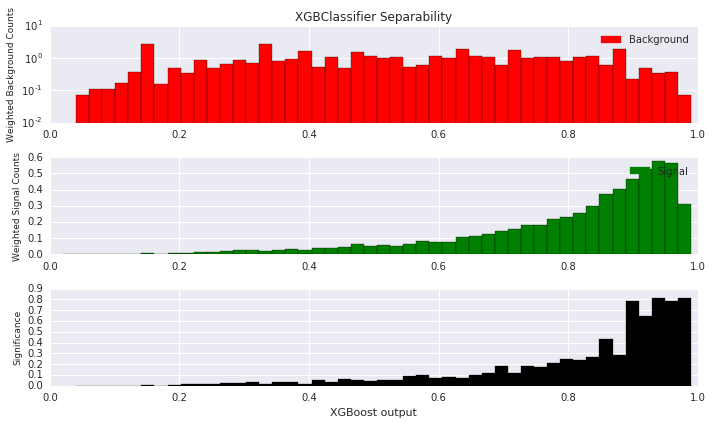

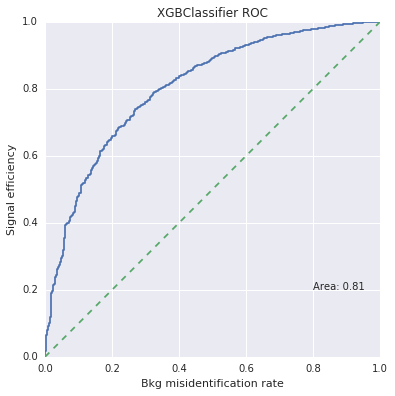

In [17]:
check_MLoutput(df_0_te, prename="SFOS0")

/cvmfs/sft.cern.ch/lcg/views/LCG_91python3/x86_64-slc6-gcc62-opt/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in true_divide


cut: 0.72; max sig : 0.6758; Nsig : 5.1; Nbkg : 55.2
Cutbased: Significance 0.449 NSig: 3.164 NBkg 48.684 
Done!


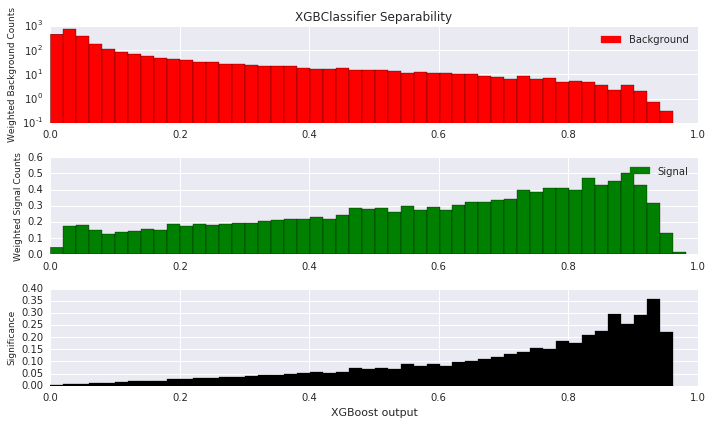

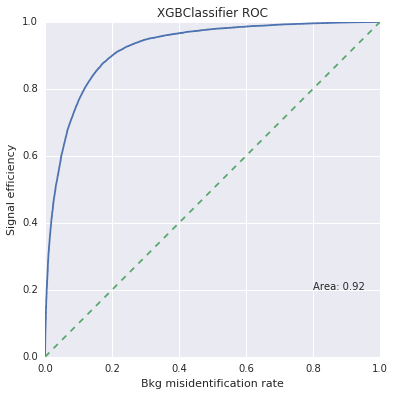

In [18]:
check_MLoutput(df_1_te, prename="SFOS1")

/cvmfs/sft.cern.ch/lcg/views/LCG_91python3/x86_64-slc6-gcc62-opt/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in true_divide


cut: 0.54; max sig : 0.3372; Nsig : 2.8; Nbkg : 67.9
Cutbased: Significance 0.231 NSig: 1.303 NBkg 31.487 
Done!


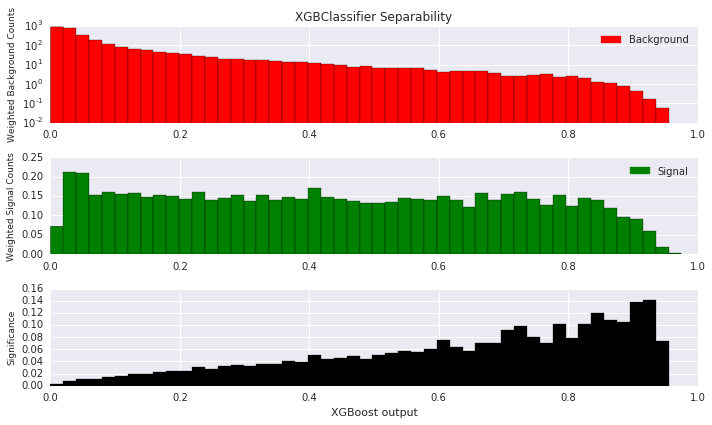

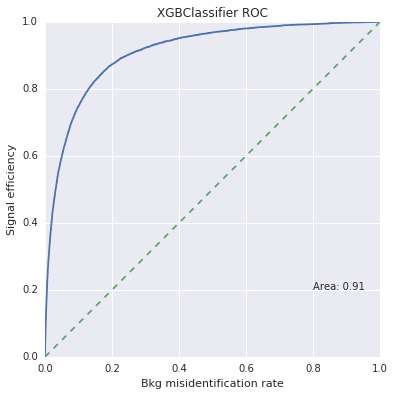

In [19]:
check_MLoutput(df_2_te, prename="SFOS2")

## Interpretations

In [20]:
def interpret_MLoutput(df, prename=""):
    for var in tqdm(x_cols):
#         if "_" not in var:
#             continue
        colors = ['r', 'b']
        title  = {0: 'background', 1: 'signal'}

        ###2D plot
        plt.clf()
        f, axes = plt.subplots(1, 2, sharey=True)
        for sig in [0, 1]:        
            x = df[df['is_sig'] == sig][var]
            y = df[df['is_sig'] == sig]['preds']
            weight = df[df['is_sig'] == sig]['weight']
            #print("fill")
            if ("m_3l" in var):
                h = axes[sig].hist2d(x, y, bins=[20, 10], range=[[0, 500], [0, 1]])
            elif ("met_pt" in var):
                h = axes[sig].hist2d(x, y, bins=[20, 10], range=[[0, 400], [0, 1]])
            elif ("phi" in var):
                h = axes[sig].hist2d(x, y, bins=[20, 10], range=[[-np.pi, np.pi], [0, 1]])
            elif ("pt" in var):
                h = axes[sig].hist2d(x, y, bins=[20, 10], range=[[0, 200], [0, 1]])
            elif ("mt" in var):
                h = axes[sig].hist2d(x, y, bins=[20, 10], range=[[0, 250], [0, 1]])
            elif ("_m" in var):
                h = axes[sig].hist2d(x, y, bins=[20, 10], range=[[0, 120], [0, 1]])
            else:
                h = axes[sig].hist2d(x, y, bins=[20, 16], range=[[min(x), max(x)], [0, 1]])
            axes[sig].set_ylabel('classifier output')
            axes[sig].set_xlabel(str(var))
            axes[sig].set_title(title[sig])
        plt.savefig("../plots/" + prename + str(var) + ".pdf")
        
        ###1D plot
        plt.clf()
        ## select signal like region
        h_sig = df.query('preds > 0.7')[df['is_sig'] == 1][var]
        h_bkg = df.query('preds < 0.5')[df['is_sig'] == 0][var]
        #y = df[df['is_sig'] == sig]['preds']
        #weight = df[df['is_sig'] == sig]['weight']
        #print("fill")
        n_bins = 20
        if ("m_3l" in var):
            plt.hist(h_sig, bins=n_bins, range=[0, 500], label="sig", normed=True, alpha=0.5)
            plt.hist(h_bkg, bins=n_bins, range=[0, 500], label="bkg", normed=True, alpha=0.5)
        elif ("met_pt" in var):
            plt.hist(h_sig, bins=n_bins, range=[0, 400], label="sig", normed=True, alpha=0.5)
            plt.hist(h_bkg, bins=n_bins, range=[0, 400], label="bkg", normed=True, alpha=0.5)
        elif ("phi" in var):
            plt.hist(h_sig, bins=n_bins, range=[-np.pi, np.pi], label="sig", normed=True, alpha=0.5)
            plt.hist(h_bkg, bins=n_bins, range=[-np.pi, np.pi], label="bkg", normed=True, alpha=0.5)
        elif ("pt" in var):
            plt.hist(h_sig, bins=n_bins, range=[0, 200], label="sig", normed=True, alpha=0.5)
            plt.hist(h_bkg, bins=n_bins, range=[0, 200], label="bkg", normed=True, alpha=0.5)
        elif ("mt" in var):
            plt.hist(h_sig, bins=n_bins, range=[0, 250], label="sig", normed=True, alpha=0.5)
            plt.hist(h_bkg, bins=n_bins, range=[0, 250], label="bkg", normed=True, alpha=0.5)
        elif ("_m" in var):
            plt.hist(h_sig, bins=n_bins, range=[0, 200], label="sig", normed=True, alpha=0.5)
            plt.hist(h_bkg, bins=n_bins, range=[0, 200], label="bkg", normed=True, alpha=0.5)
        else:
            plt.hist(h_sig, bins=n_bins, range=[min(x), max(x)], label="sig", normed=True, alpha=0.5)
            plt.hist(h_bkg, bins=n_bins, range=[min(x), max(x)], label="bkg", normed=True, alpha=0.5)

        plt.xlabel(str(var))
        plt.ylabel("normalized")
        plt.title(str(var) + " comparisons")
        plt.legend(loc='upper right')
        plt.savefig("../plots/" + prename + "_1D_" + str(var) + ".pdf")

  0%|          | 0/13 [00:00<?, ?it/s]/cvmfs/sft.cern.ch/lcg/views/LCG_91python3/x86_64-slc6-gcc62-opt/lib/python3.5/site-packages/ipykernel/__main__.py:38: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/cvmfs/sft.cern.ch/lcg/views/LCG_91python3/x86_64-slc6-gcc62-opt/lib/python3.5/site-packages/ipykernel/__main__.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
100%|██████████| 13/13 [00:13<00:00,  1.06s/it]


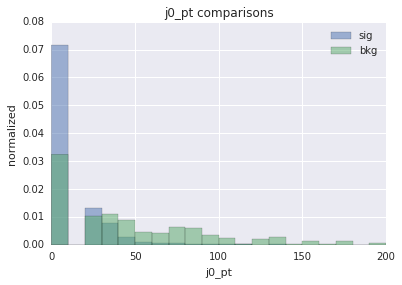

In [21]:
interpret_MLoutput(df_0_te, prename="SFOS0")
#interpret_MLoutput(df_1_te, prename="SFOS1")
#interpret_MLoutput(df_2_te, prename="SFOS2")

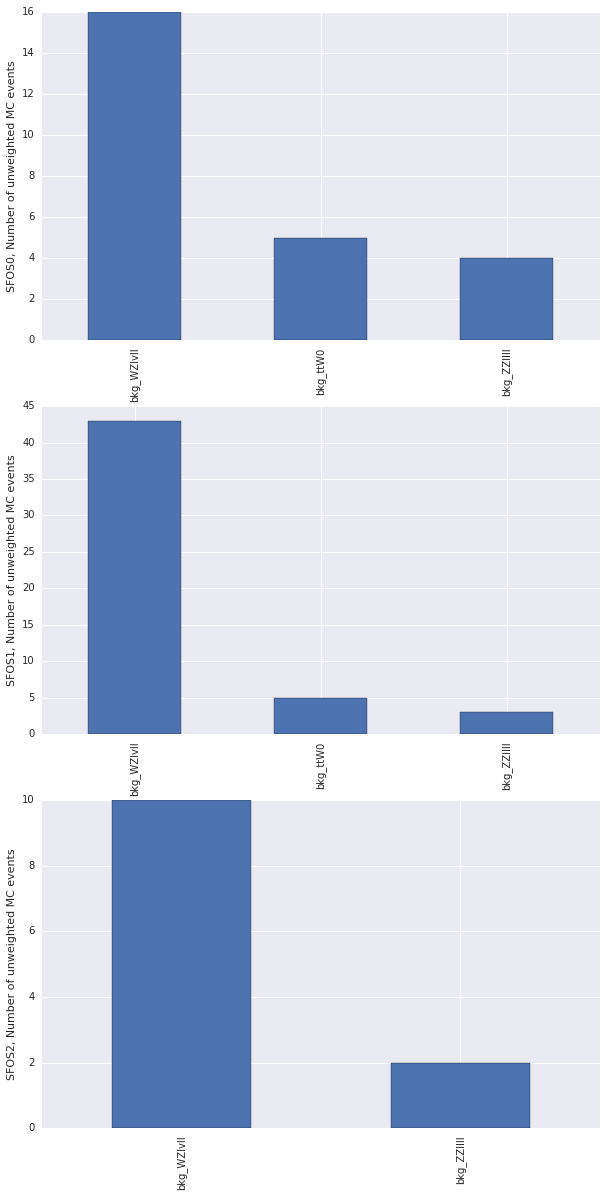

In [22]:
plt.clf()
fig = plt.figure(figsize=(10,20))
gs = gridspec.GridSpec(3, 1)
ax = plt.subplot(gs[0,:])
df_0_te.query('preds > 0.92 & is_sig == 0').cl.value_counts().plot(kind='bar')
plt.ylabel('SFOS0, Number of unweighted MC events')
ax = plt.subplot(gs[1,:])
df_1_te.query('preds > 0.9 & is_sig == 0').cl.value_counts().plot(kind='bar')
plt.ylabel('SFOS1, Number of unweighted MC events')
ax = plt.subplot(gs[2,:])
df_2_te.query('preds > 0.9 & is_sig == 0').cl.value_counts().plot(kind='bar')
plt.ylabel('SFOS2, Number of unweighted MC events')
#apply(pd.value_counts).plot(kind='bar', subplots=True)
#plt.hist(df_1.query('preds > 0.6').cl)

In [26]:
def plot_corr(df, prename="", size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.
    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    plt.clf()
    #print(corr)
    plt.imshow(corr, aspect='auto', interpolation='nearest', vmin=-1.0, vmax=1.0, cmap=plt.get_cmap("hot"))
    plt.xlabel(prename + " features")
    plt.ylabel(prename + " features")
    plt.xticks(range(len(corr.columns)), corr.columns)
    plt.yticks(range(len(corr.columns)), corr.columns)
    cb = plt.colorbar(orientation='vertical')
    cb.set_label("corr")
    plt.savefig("../plots/" + prename + "corrMatrix" + ".pdf", dpi = 300)
    plt.show()

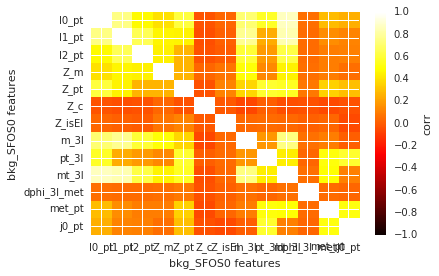

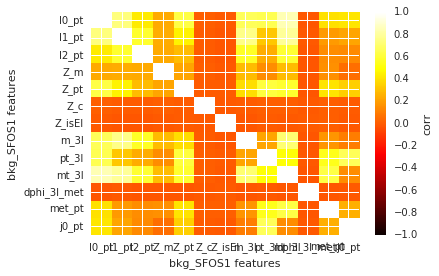

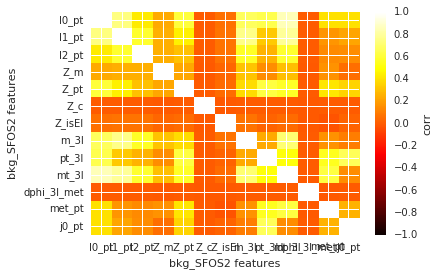

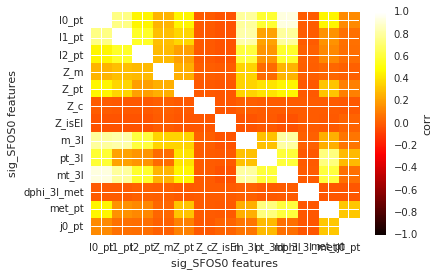

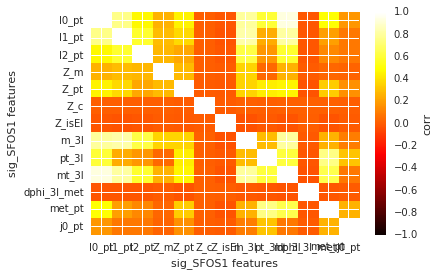

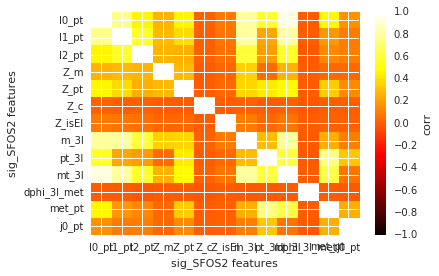

In [27]:
plot_corr(df_0_te.query('is_sig == 0')[x_cols], prename="bkg_SFOS0")
plot_corr(df_1_te.query('is_sig == 0')[x_cols], prename="bkg_SFOS1")
plot_corr(df_2_te.query('is_sig == 0')[x_cols], prename="bkg_SFOS2")
plot_corr(df_0_te.query('is_sig == 1')[x_cols], prename="sig_SFOS0")
plot_corr(df_1_te.query('is_sig == 1')[x_cols], prename="sig_SFOS1")
plot_corr(df_2_te.query('is_sig == 1')[x_cols], prename="sig_SFOS2")

## Data & MC Comparison

In [28]:
### process data with cuts
df_data_0 = df_data.loc[df_data.SFOS == 0, :]
df_data_0 = df_data_0.query('Nbjet < 1')
df_data_0 = df_data_0.query('Njet < 2')
df_data_0 = df_data_0.query('passSel == 1')
df_data_0['preds'] = xgb_0.predict_proba(df_data_0[x_cols])[:,1]

df_data_1 = df_data.loc[df_data.SFOS == 1, :]
df_data_1 = df_data_1.query('Nbjet < 1')
df_data_1 = df_data_1.query('Njet < 2')
df_data_1 = df_data_1.query('passSel == 1')
df_data_1['preds'] = xgb_1.predict_proba(df_data_1[x_cols])[:,1]


df_data_2 = df_data.loc[df_data.SFOS == 2, :]
df_data_2 = df_data_2.query('Nbjet < 1')
df_data_2 = df_data_2.query('Njet < 2')
df_data_2 = df_data_2.query('passSel == 1')
df_data_2['preds'] = xgb_2.predict_proba(df_data_2[x_cols])[:,1]

N_data 2.45e+03 N_mc 825


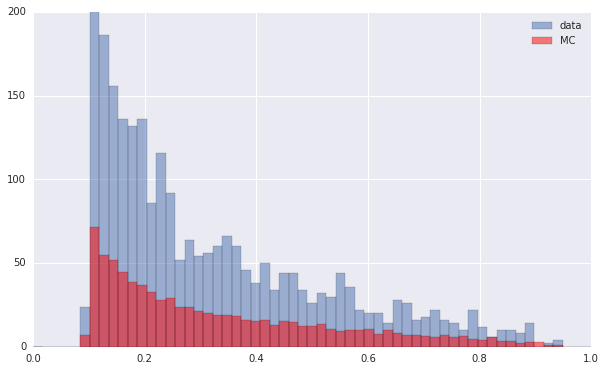

In [38]:
def check_datamc(df_data, df_mc):
    plt.clf()
    nsteps = 60
    x_bins = np.linspace(0, 1, nsteps)
    fig = plt.figure(figsize=(10,6))
    cut = 0.1
    df_temp_data = df_data.query("preds > %.3g"%cut)
    df_temp_mc = df_mc.query("preds > %.3g"%cut)
    n_bkg_data,bins,paint = plt.hist(df_temp_data.preds, bins=x_bins, alpha=0.5, label="data")
    n_bkg_mc,bins,paint = plt.hist(df_temp_mc.preds, bins=x_bins, label="MC",
                                weights=df_temp_mc.weight /(( 1 - split_factor)), color='r', alpha=0.5)
    plt.legend(loc='best', shadow=False)
    print("N_data %.3g N_mc %.3g" % (sum(n_bkg_data), sum(n_bkg_mc)))
    return

check_datamc(df_data_1, df_1_te)

In [32]:
# x_cols = [
# #           'l0_l1_m', 'l0_l1_pt', 'l0_l1_c', 
# #           'l1_l2_m', 'l1_l2_pt', 'l1_l2_c', 
# #           'l2_l0_m', 'l2_l0_pt', 'l2_l0_c', 
#           #'l0_l1_isEl', 'l1_l2_isEl', 'l2_l0_isEl', 
#           #'l0_phi', 'l1_phi', 'l2_phi', 
#           'l0_pt', 'l1_pt', 'l2_pt', 
#           'Z_m', 'Z_pt', 'Z_c', 'Z_isEl',
# #           'W_mt', 'W_pt',
# #          'm_3l', 'pt_3l', 
# #          'mt_3l',  
#           'dphi_3l_met',
#           #'mnew_3l', 
#           'met_pt',
#           #'Nmu',
# #          'j0_pt',
#           #'met_phi',
#          ]


# ##Cut based sig is 1.050
# ##with W, Z, l pT, allpair, 3l -- 0.815/0.877; test Sig 1.826
# ##with W, Z, allpair, 3l -- 0.806/0.868; test Sig 1.951
# ##with W, Z, l pT, 3l -- 0.779/0.836; test Sig 1.456
# ##with Z, l pT, 3l -- 0.778/0.834; test Sig 1.543
# ##with Z, l pT -- 0.771/0.823; test Sig 1.485 --hints the baseline cuts needs to be tuned
# xgb_0 = training(df_0_tr, x_cols, name="xgb_0")

# df_0_te['preds'] = xgb_0.predict_proba(df_0_te[x_cols])[:,1]

# check_MLoutput(df_0_te, prename="SFOS0")